In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *

# Modeling
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, PolynomialFeatures, SplineTransformer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Performance
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.calibration import calibration_curve
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier

# Model Validation
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, GridSearchCV

# Pipeline and Imputation
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

import re
%matplotlib inline


# Preprocessing

In [ ]:
spotify = pd.read_csv("Most Streamed Spotify Songs 2024.csv", encoding='ISO-8859-1')
spotify.head()

,Track,Album Name,Artist,Release Date,ISRC,All Time Rank,Track Score,Spotify Streams,Spotify Playlist Count,Spotify Playlist Reach,...,SiriusXM Spins,Deezer Playlist Count,Deezer Playlist Reach,Amazon Playlist Count,Pandora Streams,Pandora Track Stations,Soundcloud Streams,Shazam Counts,TIDAL Popularity,Explicit Track
0,MILLION DOLLAR BABY,Million Dollar Baby - Single,Tommy Richman,4/26/2024,QM24S2402528,1,725.4,"390,470,936","30,716","196,631,588",...,684,62.0,"17,598,718",114.0,"18,004,655","22,931","4,818,457","2,669,262",NaN,0
1,Not Like Us,Not Like Us,Kendrick Lamar,5/4/2024,USUG12400910,2,545.9,"323,703,884","28,113","174,597,137",...,3,67.0,"10,422,430",111.0,"7,780,028","28,444","6,623,075","1,118,279",NaN,1
2,i like the way you kiss me,I like the way you kiss me,Artemas,3/19/2024,QZJ842400387,3,538.4,"601,309,283","54,331","211,607,669",...,536,136.0,"36,321,847",172.0,"5,022,621","5,639","7,208,651","5,285,340",NaN,0
3,Flowers,Flowers - Single,Miley Cyrus,1/12/2023,USSM12209777,4,444.9,"2,031,280,633","269,802","136,569,078",...,"2,182",264.0,"24,684,248",210.0,"190,260,277","203,384",NaN,"11,822,942",NaN,0
4,Houdini,Houdini,Eminem,5/31/2024,USUG12403398,5,423.3,"107,034,922","7,223","151,469,874",...,1,82.0,"17,660,624",105.0,"4,493,884","7,006","207,179","457,017",NaN,1


In [ ]:
spotify.columns

Index(['Track', 'Album Name', 'Artist', 'Release Date', 'ISRC',
       'All Time Rank', 'Track Score', 'Spotify Streams',
       'Spotify Playlist Count', 'Spotify Playlist Reach',
       'Spotify Popularity', 'YouTube Views', 'YouTube Likes', 'TikTok Posts',
       'TikTok Likes', 'TikTok Views', 'YouTube Playlist Reach',
       'Apple Music Playlist Count', 'AirPlay Spins', 'SiriusXM Spins',
       'Deezer Playlist Count', 'Deezer Playlist Reach',
       'Amazon Playlist Count', 'Pandora Streams', 'Pandora Track Stations',
       'Soundcloud Streams', 'Shazam Counts', 'TIDAL Popularity',
       'Explicit Track'],
      dtype='object')

In [ ]:
# Check for Missing Values

spotify.isnull().sum()

# A lot of missing values, better to not drop

,0
Track,0
Album Name,0
Artist,5
Release Date,0
ISRC,0
All Time Rank,0
Track Score,0
Spotify Streams,113
Spotify Playlist Count,70
Spotify Playlist Reach,72


In [ ]:
# Used in Questions 1 & 2

# Function to remove commas and convert to floats - Idea given by ChatGPT

def clean_and_convert(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.replace(',', '').astype(float)
    return df

# Continuous predictors
cont_predictors = [
    "Track Score", "Spotify Streams", "Spotify Playlist Count", "Spotify Playlist Reach",
    "Spotify Popularity", "YouTube Views", "YouTube Likes", "TikTok Posts", "TikTok Likes", "TikTok Views",
    "YouTube Playlist Reach", "Apple Music Playlist Count", "AirPlay Spins", "SiriusXM Spins",
    "Deezer Playlist Count", "Deezer Playlist Reach", "Amazon Playlist Count", "Pandora Streams",
    "Pandora Track Stations", "Soundcloud Streams", "Shazam Counts"
] #TIDAL Popularity only has missing values, dropped because of this

# Categorical predictors - Don't Use Function
cat_predictors = ["Track", "Album Name", "Artist", "Release Date", "Explicit Track"] #Exclude ISRC, not relevant

# Call function on variables
spotify = clean_and_convert(spotify, cont_predictors)
spotify = clean_and_convert(spotify, ['All Time Rank'])

# Convert columns in cont_predictors to numeric
for col in cont_predictors:
    spotify[col] = pd.to_numeric(spotify[col], errors='coerce')

X = spotify[cont_predictors + cat_predictors]
y = spotify["All Time Rank"]

# Impute missing values in predictors
imputer_cont = SimpleImputer(strategy='mean')
X_cont_imputed = imputer_cont.fit_transform(X[cont_predictors])

X[cont_predictors] = pd.DataFrame(X_cont_imputed, columns=cont_predictors)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)

# Scale continuous predictors
scaler = StandardScaler()
X_train_cont_scaled = scaler.fit_transform(X_train[cont_predictors])
X_test_cont_scaled = scaler.transform(X_test[cont_predictors])

# Encode categorical predictors
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore') #handle_unknown = 'ignore' ignores unseen information, used to avoid recurring error
X_train_cat_encoded = encoder.fit_transform(X_train[cat_predictors])
X_test_cat_encoded = encoder.transform(X_test[cat_predictors])

# Concatenate continuous and categorical predictors
X_train_final = np.concatenate([X_train_cont_scaled, X_train_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_cont_scaled, X_test_cat_encoded], axis=1)

# Q1: How does the song’s Explicit Track impact its performance on Spotify, YouTube, and TikTok?

In [ ]:
# Step 1: Select relevant columns from the dataset
explicit_df = spotify[["Explicit Track", "Spotify Streams", "YouTube Views", "TikTok Views"]]

# Step 2: Drop missing values
explicit_df.dropna(inplace=True)
explicit_df.reset_index(inplace=True, drop=True)

# Step 3: Handle object-type columns (strings with commas or other non-numeric characters)
for predictor in ["Spotify Streams", "YouTube Views", "TikTok Views"]:
    if explicit_df[predictor].dtype == 'object':
        # Remove commas and convert to float
        explicit_df[predictor] = explicit_df[predictor].str.replace(',', '').astype(float)

# Step 4: Prepare features (X) and target (y) variables
X = explicit_df[["Explicit Track"]]  # Use 'Explicit Track' as the feature
y_spotify = explicit_df["Spotify Streams"]
y_youtube = explicit_df["YouTube Views"]
y_tiktok = explicit_df["TikTok Views"]

# Step 5: Train-test split (80/20) for each target variable
X_train2, X_test2, y_train_spotify2, y_test_spotify2 = train_test_split(X, y_spotify, test_size=0.2, random_state=42)
X_train2, X_test2, y_train_youtube2, y_test_youtube2 = train_test_split(X, y_youtube, test_size=0.2, random_state=42)
X_train2, X_test2, y_train_tiktok2, y_test_tiktok2 = train_test_split(X, y_tiktok, test_size=0.2, random_state=42)

# Step 6: Define and fit the Linear Regression model for Spotify
linear_lr = LinearRegression()
linear_lr.fit(X_train2, y_train_spotify2)

# Step 7: Predict and evaluate for Spotify
y_pred_train_linear = linear_lr.predict(X_train2)
y_pred_test_linear = linear_lr.predict(X_test2)

print("Spotify Linear Regression Results:")
print("Train MSE : ", mean_squared_error(y_train_spotify2, y_pred_train_linear))
print("Train MAE : ", mean_absolute_error(y_train_spotify2, y_pred_train_linear))
print("Train R2  : ", r2_score(y_train_spotify2, y_pred_train_linear))
print()
print("Test MSE  : ", mean_squared_error(y_test_spotify2, y_pred_test_linear))
print("Test MAE  : ", mean_absolute_error(y_test_spotify2, y_pred_test_linear))
print("Test R2   : ", r2_score(y_test_spotify2, y_pred_test_linear))
print()

# Step 8: Define and fit the Linear Regression model for YouTube
linear_lr.fit(X_train2, y_train_youtube2)
y_pred_train_linear = linear_lr.predict(X_train2)
y_pred_test_linear = linear_lr.predict(X_test2)

print("YouTube Linear Regression Results:")
print("Train MSE : ", mean_squared_error(y_train_youtube2, y_pred_train_linear))
print("Train MAE : ", mean_absolute_error(y_train_youtube2, y_pred_train_linear))
print("Train R2  : ", r2_score(y_train_youtube2, y_pred_train_linear))
print()
print("Test MSE  : ", mean_squared_error(y_test_youtube2, y_pred_test_linear))
print("Test MAE  : ", mean_absolute_error(y_test_youtube2, y_pred_test_linear))
print("Test R2   : ", r2_score(y_test_youtube2, y_pred_test_linear))
print()

# Step 9: Define and fit the Linear Regression model for TikTok
linear_lr.fit(X_train2, y_train_tiktok2)
y_pred_train_linear = linear_lr.predict(X_train2)
y_pred_test_linear = linear_lr.predict(X_test2)

print("TikTok Linear Regression Results:")
print("Train MSE : ", mean_squared_error(y_train_tiktok2, y_pred_train_linear))
print("Train MAE : ", mean_absolute_error(y_train_tiktok2, y_pred_train_linear))
print("Train R2  : ", r2_score(y_train_tiktok2, y_pred_train_linear))
print()
print("Test MSE  : ", mean_squared_error(y_test_tiktok2, y_pred_test_linear))
print("Test MAE  : ", mean_absolute_error(y_test_tiktok2, y_pred_test_linear))
print("Test R2   : ", r2_score(y_test_tiktok2, y_pred_test_linear))


Spotify Linear Regression Results:
Train MSE :  2.8599829710663197e+17
Train MAE :  397119629.2749719
Train R2  :  0.0017319993014867086

Test MSE  :  2.933616758434929e+17
Test MAE  :  404616511.69773465
Test R2   :  -0.006765061682816986

YouTube Linear Regression Results:
Train MSE :  5.33236734589257e+17
Train MAE :  420766554.1630728
Train R2  :  0.02454226134025983

Test MSE  :  3.974062706843062e+17
Test MAE  :  398001625.1666651
Test R2   :  0.00996622756069121

TikTok Linear Regression Results:
Train MSE :  4.2273369848296464e+19
Train MAE :  1431203533.6070998
Train R2  :  0.00024960833480081046

Test MSE  :  3.63605780308583e+18
Test MAE  :  1212709823.110779
Test R2   :  -0.009590504671762146


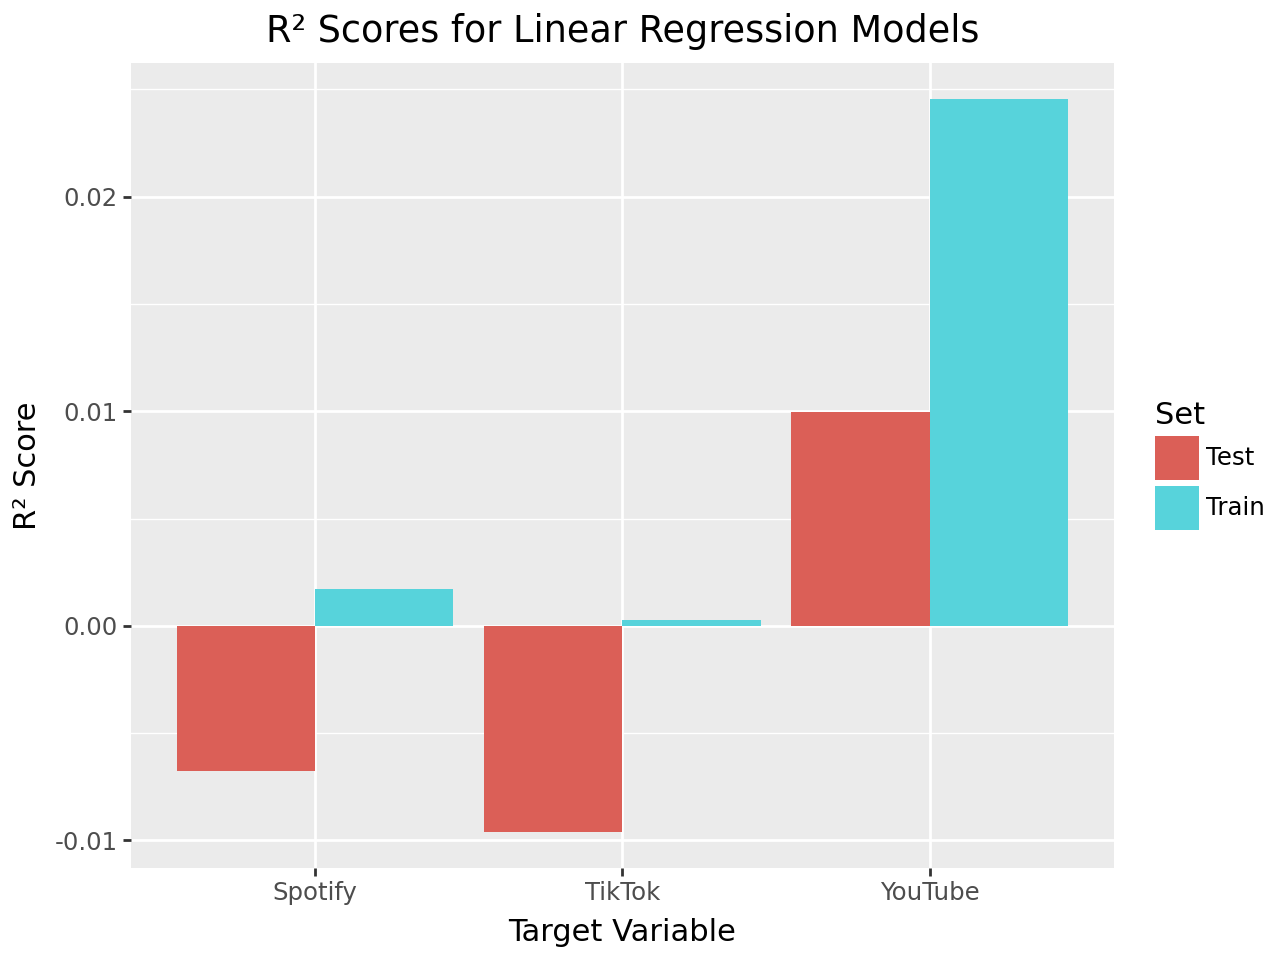

In [ ]:
# Prepare R² scores for plotting
r2_data = pd.DataFrame({
    "Target": ["Spotify", "Spotify", "YouTube", "YouTube", "TikTok", "TikTok"],
    "Set": ["Train", "Test", "Train", "Test", "Train", "Test"],
    "R2_Score": [
        0.0017319993014867086,  # Spotify Train
        -0.006765061682816986,  # Spotify Test
        0.02454226134025983,    # YouTube Train
        0.00996622756069121,    # YouTube Test
        0.00024960833480081046, # TikTok Train
        -0.009590504671762146   # TikTok Test
    ]
})

# Create bar chart using ggplot
(ggplot(r2_data, aes(x="Target", y="R2_Score", fill="Set"))
 + geom_bar(stat="identity", position="dodge")
 + labs(title="R² Scores for Linear Regression Models",
        x="Target Variable",
        y="R² Score")
 + theme(axis_text_x=element_text()
 + theme_minimal()
))


In [ ]:
explicit_df["Explicit Track"] = explicit_df["Explicit Track"].astype("category")

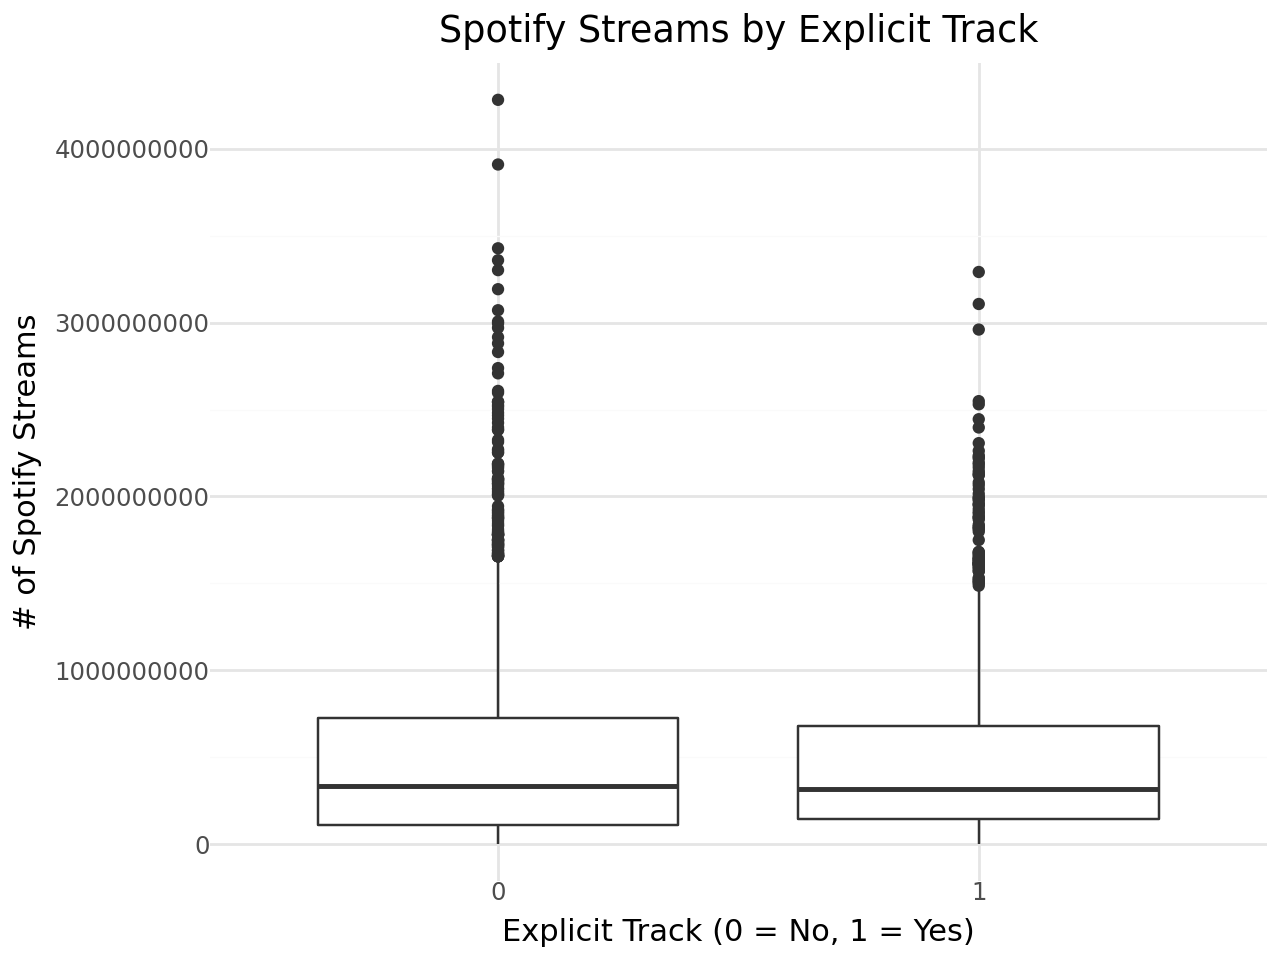

In [ ]:
# Boxplot for Spotify Streams by Explicit Track

(ggplot(explicit_df, aes(x = "Explicit Track", y = "Spotify Streams"))
+ geom_boxplot()
+ labs(title = "Spotify Streams by Explicit Track",
       x = "Explicit Track (0 = No, 1 = Yes)",
       y = "# of Spotify Streams")
+ theme_minimal())

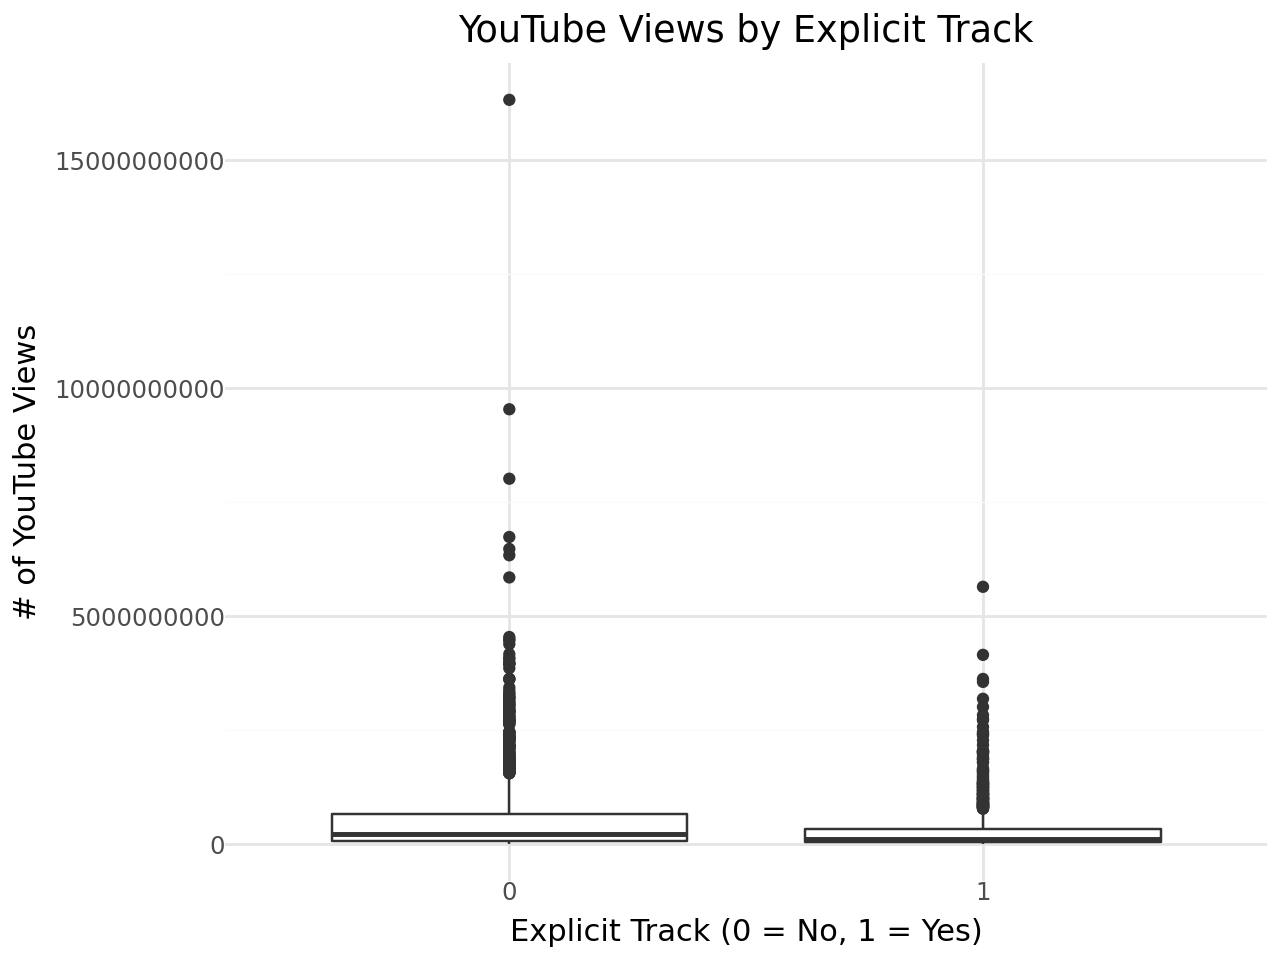

In [ ]:
# Boxplot for YouTube Views by Explicit Track

(ggplot(explicit_df, aes(x = "Explicit Track", y = "YouTube Views"))
+ geom_boxplot()
+ labs(title = "YouTube Views by Explicit Track",
       x = "Explicit Track (0 = No, 1 = Yes)",
       y = "# of YouTube Views")
+ theme_minimal())

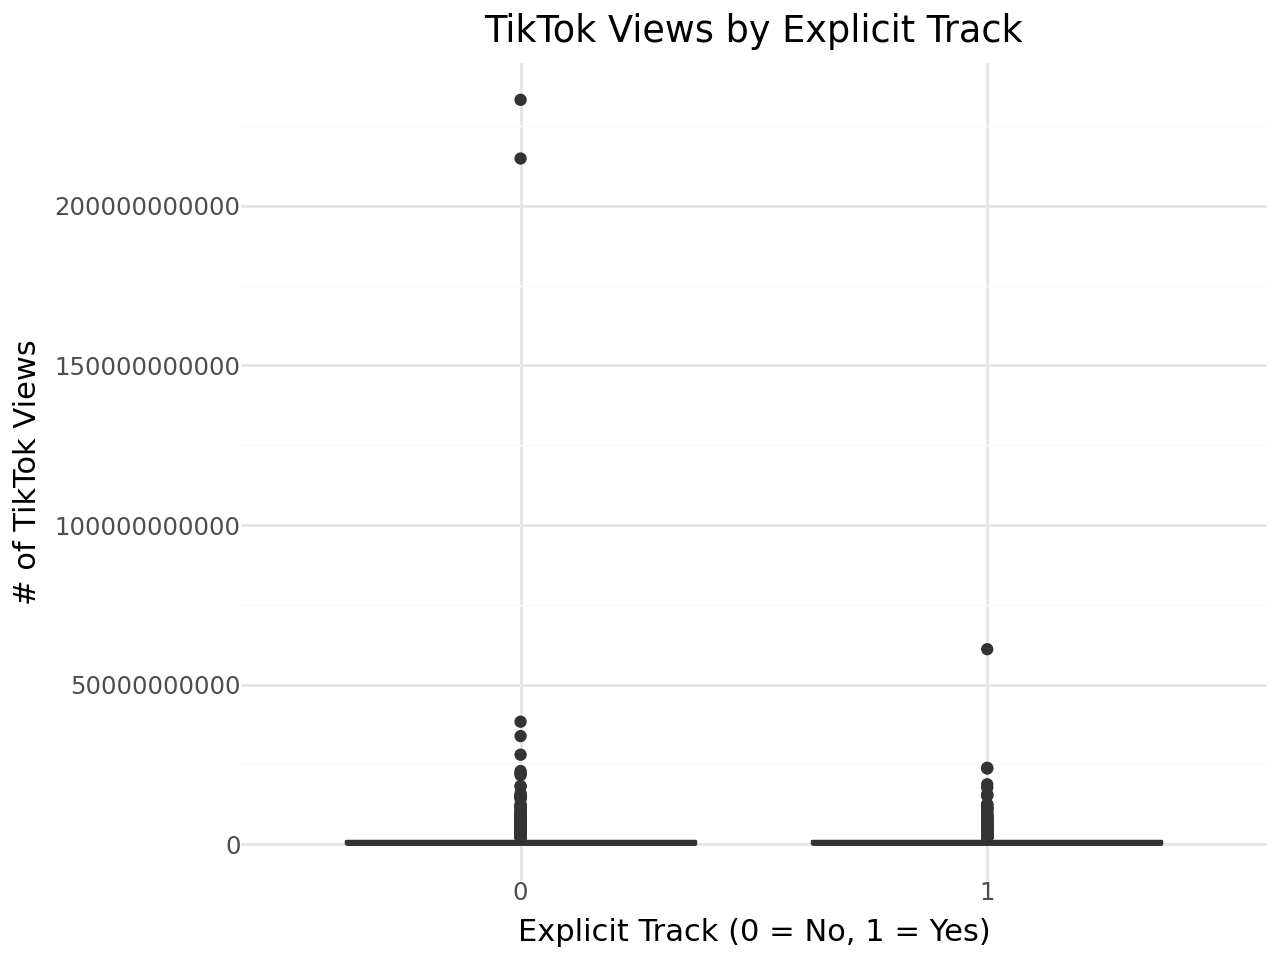

In [ ]:
# Boxplot for TikTok Views by Explicit Track

(ggplot(explicit_df, aes(x = "Explicit Track", y = "TikTok Views"))
+ geom_boxplot()
+ labs(title = "TikTok Views by Explicit Track",
       x = "Explicit Track (0 = No, 1 = Yes)",
       y = "# of TikTok Views")
+ theme_minimal())


# Q2: Group songs based on their performance across streaming platforms in terms of how many views/streams received on music platforms (Spotify, YouTube, TikTok, etc.). Can they be clustered appropriately this way? Use K-Means and evaluate their performance.

In [ ]:
# Step 1: Select relevant columns from the dataset
streaming_df = spotify[["Spotify Streams", "YouTube Views", "TikTok Views", "Pandora Streams", "Soundcloud Streams"]]

# Step 2: Drop missing values
streaming_df.dropna(inplace=True)
streaming_df.reset_index(inplace=True, drop=True)

# Step 3: Z-score normalize the continuous variables
scaler = StandardScaler()
scaled_data = scaler.fit_transform(streaming_df)

# Convert the scaled data back into a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=streaming_df.columns)


In [ ]:
# We will focus on:
# Spotify Streams vs YouTube Views
# Pandora Streams vs Soundcloud Views

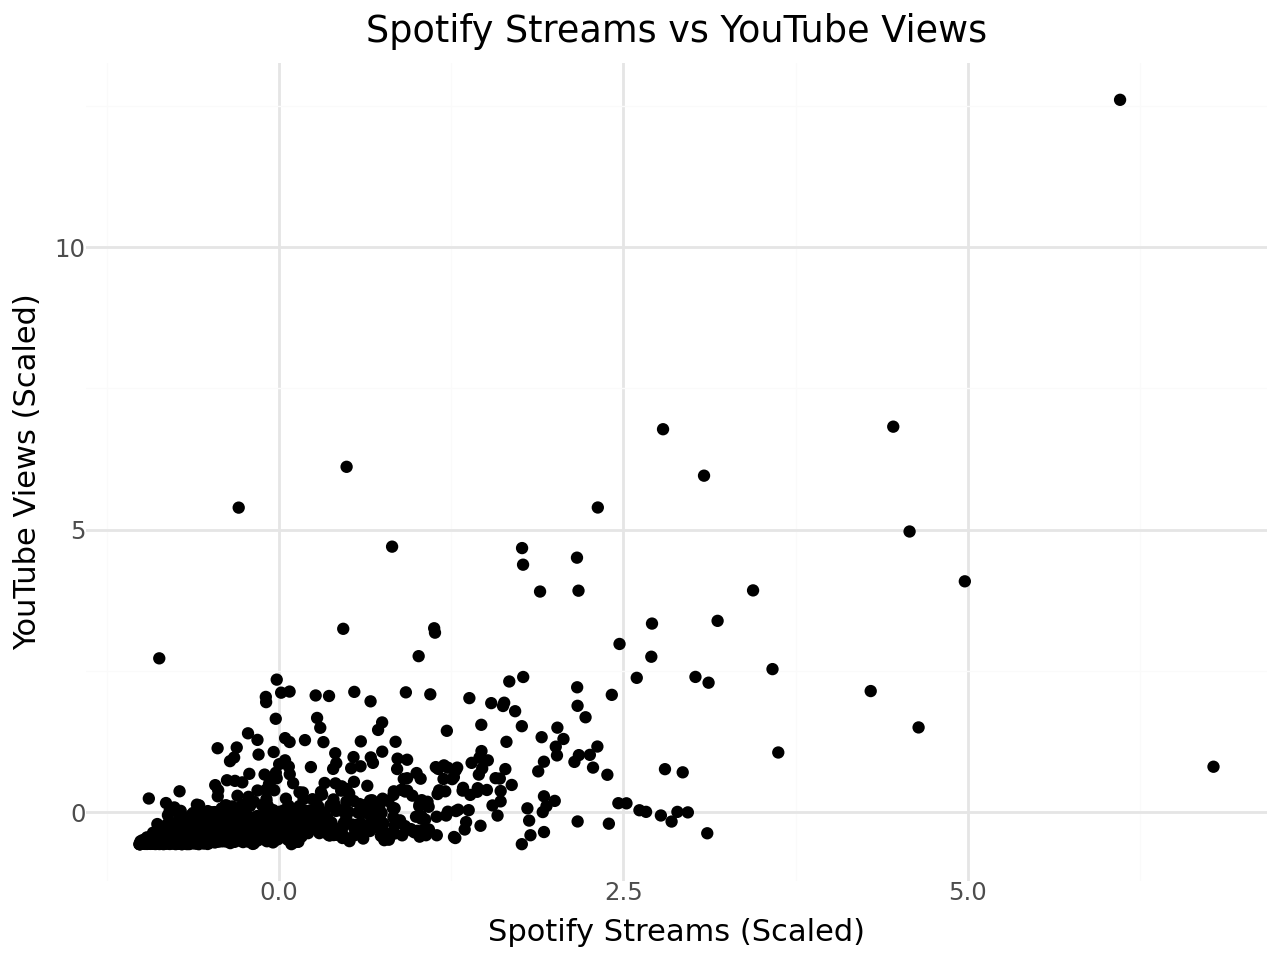

In [ ]:
# Spotify Streams vs YouTube Views
(
    ggplot(scaled_df, aes(x="Spotify Streams", y="YouTube Views"))
    + geom_point()
    + labs(title="Spotify Streams vs YouTube Views",
           x="Spotify Streams (Scaled)",
           y="YouTube Views (Scaled)")
    + theme_minimal()
)

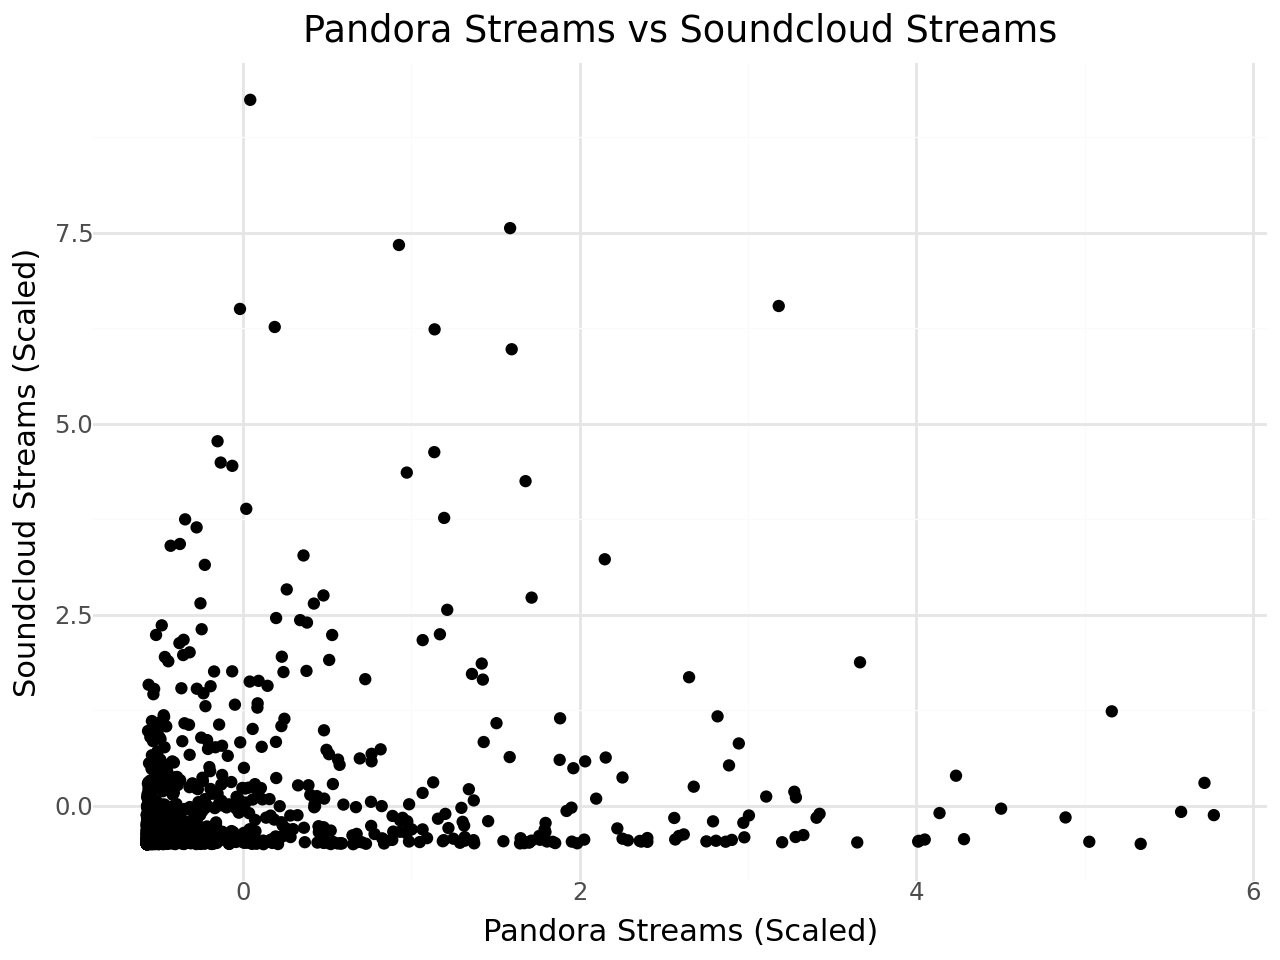

In [ ]:
# Pandora Streams vs Soundcloud Streams
(
    ggplot(scaled_df, aes(x="Pandora Streams", y="Soundcloud Streams"))
    + geom_point()
    + labs(title="Pandora Streams vs Soundcloud Streams",
           x="Pandora Streams (Scaled)",
           y="Soundcloud Streams (Scaled)")
    + theme_minimal()
)

In [ ]:
# Step 4: Apply K-Means Clustering for Spotify Streams vs YouTube Views
n_clusters = 2  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
scaled_df['clusters_km'] = kmeans.fit_predict(scaled_df)


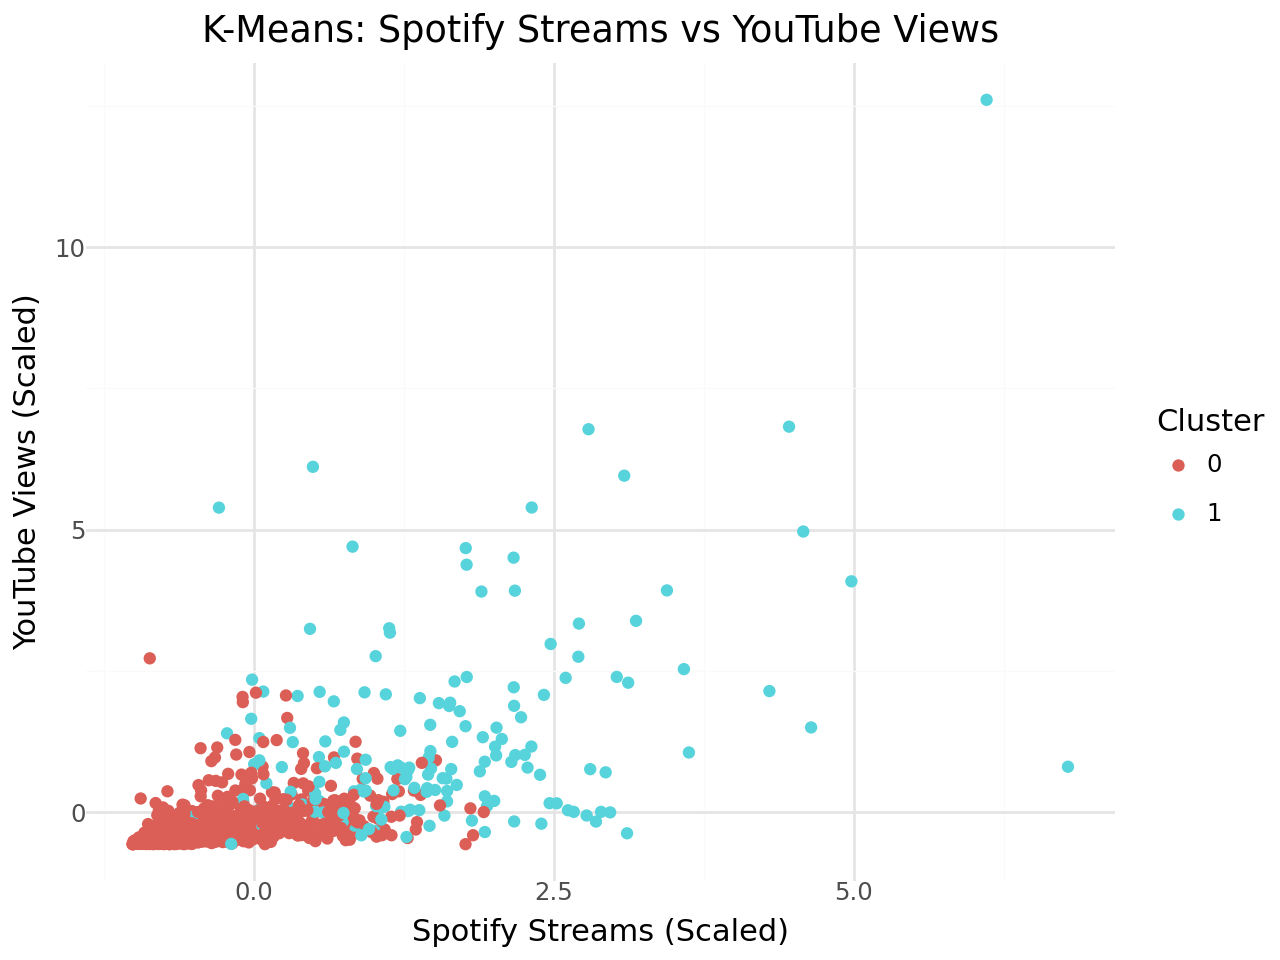

In [ ]:
# Spotify Streams vs YouTube Views
(
    ggplot(scaled_df, aes(x="Spotify Streams", y="YouTube Views", color="factor(clusters_km)"))
    + geom_point()
    + labs(title="K-Means: Spotify Streams vs YouTube Views",
           x="Spotify Streams (Scaled)",
           y="YouTube Views (Scaled)",
           color="Cluster")
    + theme_minimal()
)

In [ ]:
# Step 5: Apply K-Means Clustering for Pandora Streams vs Soundcloud Streams
n_clusters = 3  # Define the number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
scaled_df['clusters_km'] = kmeans.fit_predict(scaled_df)


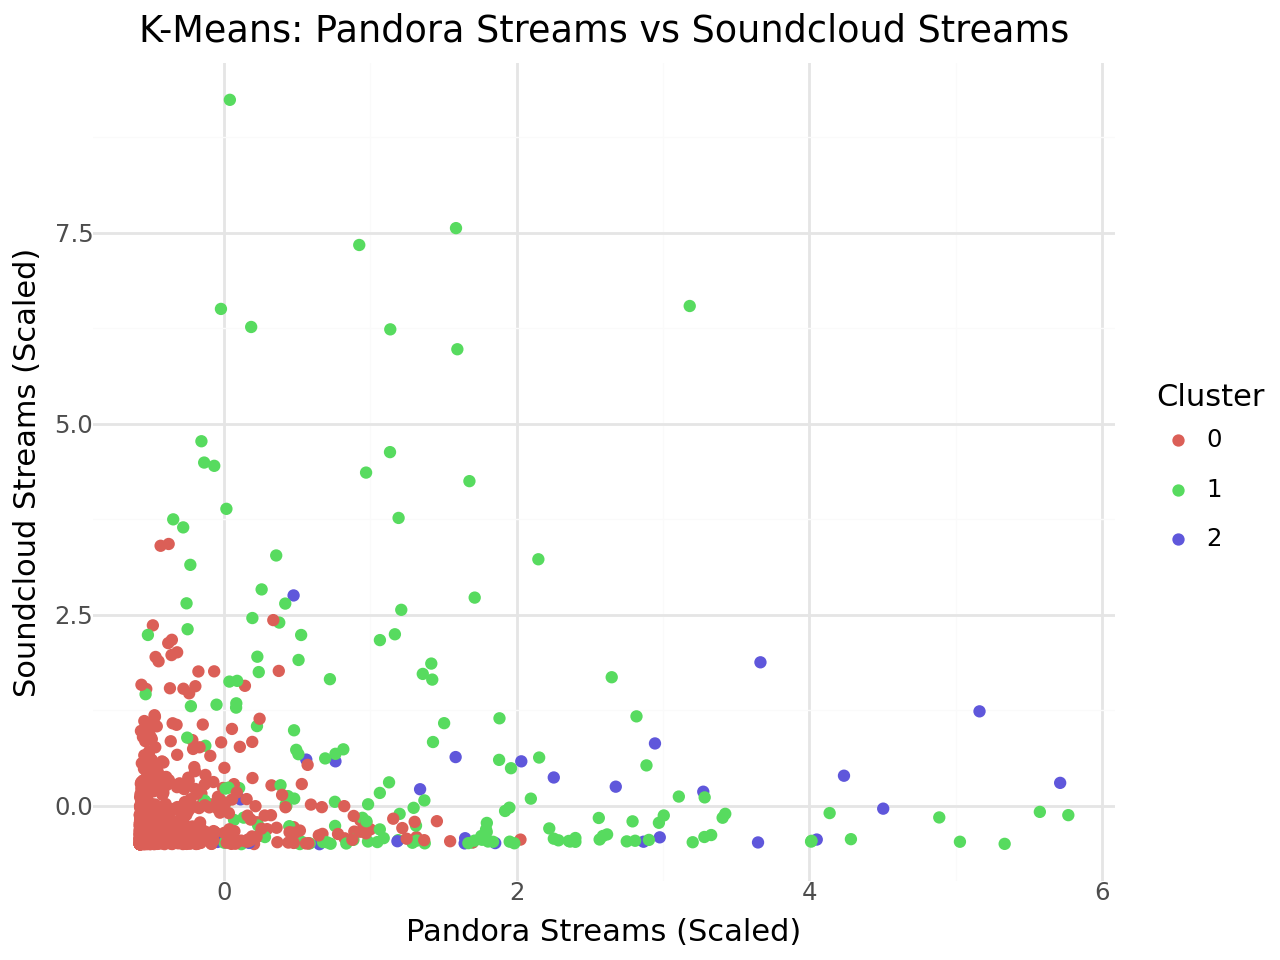

In [ ]:
# Pandora Streams vs Soundcloud Streams with K-Means
(
    ggplot(scaled_df, aes(x="Pandora Streams", y="Soundcloud Streams", color="factor(clusters_km)"))
    + geom_point()
    + labs(title="K-Means: Pandora Streams vs Soundcloud Streams",
           x="Pandora Streams (Scaled)",
           y="Soundcloud Streams (Scaled)",
           color="Cluster")
    + theme_minimal()
)